# Analysis of a one-phase (supercritical) simulation

In the previous example, we generated a macrostate distribution and average energy over a small range of number of particles.
In this example, we demonstrate how to analyze a macrostate probability distribution and average energy from the NIST SRSW for $T^*=1.5$.
You could alternatively use the previous tutorial to generate a macrostate distribution with $N_{max}=370$ rather than using the NIST SRSW data set.
If you do use your own data, then the values will not be exactly the same due to statistical error.

We begin with canonical ensemble average properties at each value of $N$ as well as the probability to observe this $N$ for a given $\mu$.
From the plots below, we can estimate our most probable state is approximately $N=310$, with an average energy of approximately $-1250$.
But there is a more rigorous way to compute grand canonical ensemble averages as described below, which will yield a more precise result and, with the help of histogram reweighting, will yield properties continuously in $N$.

Note that this tutorial uses pyfeasst (https://pypi.org/project/pyfeasst/) for analysis.

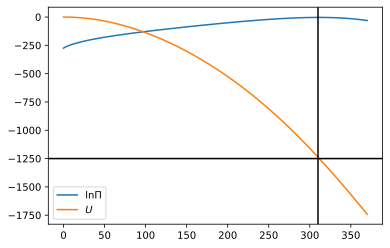

In [1]:
import numpy as np
import pandas as pd
from pyfeasst import macrostate_distribution

srsw = macrostate_distribution.read_csv(file_name="../test/data/stat150.csv",
                                        macrostate_name='N',
                                        ln_prob_name='lnPI',
                                        data_name='energy')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.plot(srsw.ln_prob(), label=r'$\ln\Pi$')
plt.plot(srsw.data(), label=r'$U$')
plt.axvline(310, color='black')
plt.axhline(-1250, color='black')
plt.legend()

Note that this macrostate distribution has only one maximum and therefore only one stable phase.
The next tutorial will consider a lower temperature with phase separation.

## Grand canonical ensemble averages

For a macrostate of the number of particles, $N$, the canonical ensemble average of some extensive quantity, $A$, from a flat histogram simulation is computed as follows:

$$\langle A\rangle_{NVT}(N) = \frac{\sum_{i=0}^{N_{trial}} A(i) \delta(n_i - N)}{\sum_{i=0}^{N_{trial}} \delta(n_i - N)},$$

where $\delta$ is the Dirac delta function.
Instead of only utilizing the canonical ensemble averages at only discrete values of the macrostate, one should instead compute a grand canonical ensemble average using the macrostate probability distribution, $\Pi$, and all of the canonical ensemble averages in the range $N \epsilon (N_{min}, N_{max})$, or $(0, 370)$ in this example.

Thus, grand canonical ensemble averages are defined as:

$$\langle A \rangle_{\mu VT}(\langle N\rangle_{\mu VT}) = \sum_{n=N_{min}}^{N_{max}}\langle A \rangle_{NVT}(n)\Pi(n; \mu)$$

Where

$$\langle N\rangle_{\mu VT} = \sum_{n=N_{min}}^{N_{max}} n\Pi(n; \mu)$$

The grand canonical averaged quantity, $A$, must be extensive.
To obtain an intensive quantity, divide $\langle A\rangle_{\mu VT}$ by $\langle N\rangle_{\mu VT}$.

As an example, $\langle N\rangle_{\mu VT}$ and $\langle U\rangle_{\mu VT}$ are computed as:

In [2]:
N_muvt = srsw.average_macrostate()
print('N =', N_muvt)
assert N_muvt == 310.41794218796804
assert N_muvt == (np.exp(srsw.ln_prob()) * srsw.macrostates()).sum()

U_muvt = srsw.average_data()
print('U =', U_muvt)
assert U_muvt == -1241.6148817462101
assert U_muvt == (np.exp(srsw.ln_prob()) * srsw.data()).sum()

N = 310.41794218796804
U = -1241.6148817462101


Now that the grand canonical ensemble averages are computed for the particular value of the chemical potential, $\mu$, the macrostate distribution can be reweighted to different chemical potentials, $\mu$.
Thus, with a continuous variation in $\mu$ one can also obtain a continuous variation in the grand canonical ensemble averages, within the limits of $N_{min}$, $N_{max}$.

What values of $N_{min}$ and $N_{max}$ should you choose for your system?
$N_{min} = 0$ is a natural choice if feasible.
These bounds, especially $N_{max}$, should be chosen such that $\Pi$ is vanishingly small and therefore the canonical ensemble average does not contribute to the grand canonical ensemble average.

## Histogram reweighting

Analysis of flat histogram simulations is greatly enhanced by the use of histogram reweighting, which allows you to obtain information continuously as a function of the macrostate's thermodynamic conjugate.
Thus, for the grand canonical ensemble with the number of particles as the macrostate, $N$, we can reweight to various values of chemical potential, $\mu$.
For microcanonical partition function, $\Omega(N,V,U)$, canonical, $Q(N,V,T)$ and grand canonical, $\Xi(\mu, V, T)$, the probability to observe a state, $\Pi$ is given by

$$\ln\Pi(N,U; \mu, V, \beta) = -\beta U + \beta \mu N + \ln\Omega(N,U,V) - \ln\Xi(\mu,V,T).$$

Therefore, the difference between two $\ln\Pi$ at different values of $\mu$ is known within a constant, C

$$\ln\Pi(N; \mu, V, \beta) = \ln\Pi_0(N; \mu_0, V, \beta) + N\beta(\mu - \mu_0) + C.$$

Thus, to reweight a histogram to a different value of $\mu$, use the equation above and remove the constant by renormalization, $\sum \Pi = 1$.
The thermodynamic conjugate to $N$ is $\beta\mu$, while the conjugate of $U$ is $-\beta$. 

N(beta_mu = -2.3333333333333335 ) = 153.44171767002885
U(beta_mu = -2.3333333333333335 ) = -321.87522543435364


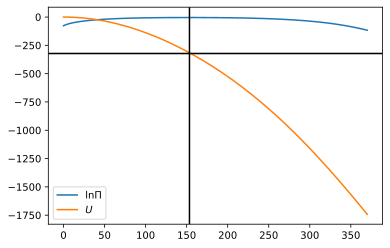

In [3]:
# reweight to a different mu and calculate the average number of particles and energy
beta_mu_rw = -2.333333333333333333
beta_mu = -1.568214

srsw.reweight(delta_beta_mu=beta_mu_rw - beta_mu, inplace=True)

N_muvt_rw = srsw.average_macrostate()
print('N(beta_mu =', beta_mu_rw, ') =', N_muvt_rw)
assert abs(N_muvt_rw - 153.44171767002885) < 1e-11

U_muvt_rw = srsw.average_data()
print('U(beta_mu =', beta_mu_rw, ') =', U_muvt_rw)
assert abs(U_muvt_rw + 321.87522543435364) < 1e-10

plt.plot(srsw.ln_prob(), label=r'$\ln\Pi$')
plt.plot(srsw.data(), label=r'$U$')
plt.axvline(N_muvt_rw, color='black')
plt.axhline(U_muvt_rw, color='black')
plt.legend()

Note that decreasing the chemical potential leads to a smaller number of particles.

When there are multiple peaks in $\ln\Pi$ whose locations are nearly invariant to system size, this often corresponds to different macroscopic phases.